In [2]:
import numpy as np
from scipy.linalg import expm
import numpy.linalg as LA
import random

from qiskit import QuantumCircuit
from qiskit import Aer, transpile,execute
from qiskit.quantum_info import random_pauli, state_fidelity, diamond_norm, Choi
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.tools.visualization import plot_histogram, plot_state_city

# def create_entanglement(Nq, qc):
#     qc.h(0)
#     for i in range(1, Nq):
#         qc.cx(0, i)
        
#     qc.barrier()
#     return qc

def create_hamiltonian(Nq, cn, gamma, Bn):
    '''
    create Hamiltonian gate
    target Hamiltonian is H=1/2*cn((1+gamma)XX+(1-gamma)YY)+BnZn
    Nq -> number of qubit
    cn -> coupling constant
    gamma -> parameter
    Bn -> Magnetic field
    '''
    
    XX= np.array(np.zeros(2**Nq))
    YY= np.array(np.zeros(2**Nq))
    Zn= np.array(np.zeros(2**Nq))
    Identity = 'I' * Nq
    hamiltonian = np.array(np.zeros(2**Nq))
    
    for k in range(0, Nq):
        '''
        隣あうqubitのみ相互作用するようなモデルを考える
        0 1 2 ... k-1 X X k+2 ... N-1
        0 1 2 ... k-1 Y Y k+2 ... N-1
        '''
        
        # 端まで計算したらスキップ
        if k == Nq-1:
            continue

        hamiX = Pauli(Identity[:k] + 'XX' + Identity[k+2:])
        hamiY = Pauli(Identity[:k] + 'YY' + Identity[k+2:])
                
#         print("hamiX: %s" % hamiX)
#         print("hamiY: %s" % hamiY)

        XX = XX + 0.5*cn[k]*(1+gamma)*hamiX.to_matrix()
        YY = YY + 0.5*cn[k]*(1-gamma)*hamiY.to_matrix()

    for k in range(0, Nq):
        hamiZ = Pauli(Identity[:k] + 'Z' + Identity[k+1:])
        Zn = Zn + Bn[k] * hamiZ.to_matrix()
    
    return XX + YY + Zn
        

In [ ]:
qubit = 5
cn = [1] * qubit #[1,1,1,1,1]
r = 0
bn = [0] * qubit #[0,0,0,0,0]

# 量子回路初期化
qc1 = QuantumCircuit(qubit)
qc2 = QuantumCircuit(qubit)

for i in range(1000):
    t = 1
    # Hamiltonianの時間発展を計算
    hami = expm(-1j*create_hamiltonian(qubit,cn,r,bn)*t)
    
    # Unitaryゲート追加
    qc1.append(Operator(hami),list(range(qubit)))
    qc2.append(Operator(hami),list(range(qubit)))
    
    # randomな確率でPauliゲート追加
    # 各bitに独立な確率でPauliゲートを追加するように修正
    if random.randint(1, 100) < 6:
        print("loop count: %s" % i)
        p1 = random_pauli(1)
        qc1.append(p1, [random.randint(0,1)])
        print(diamond_norm(Choi(qc1)))
        print(diamond_norm(Choi(qc2)))
        
    if random.randint(1,100) <3:
        print("loop count: %s" % i)
        # 全体にかかる方は低確率にしたほうが良い（10倍は違わなくて良いのではという直感）
        p2 = random_pauli(1)
        qc2.append(p2, [random.randint(0,4)])
        print(diamond_norm(Choi(qc1)))
        print(diamond_norm(Choi(qc2)))
            
# TODO Choi行列の平均を代入する

loop count: 29
1.0000000000031453
0.9999999999983593
loop count: 59
1.0000000000055418
0.9999999999994033
loop count: 60
1.000000000008072
0.9999999999935794
loop count: 130
0.9999999999985564
1.0000000000031635
loop count: 140
0.9999999999979595
0.9999999999940585
loop count: 141
1.0000000000044458
0.9999999999986081
loop count: 146
0.9999999999916319
1.0000000000085543
loop count: 172


In [ ]:
qc1.draw('mpl')

In [ ]:
backend = Aer.get_backend('unitary_simulator')
results = execute(qc1, backend=backend).result()
unitary_mat =results.get_unitary(qc1)
print(np.round(unitary_mat,4))

{'11110': 6, '11011': 142, '00100': 146, '00001': 6, '01000': 200, '10111': 220, '01111': 148, '11101': 9, '00010': 9, '10000': 138}


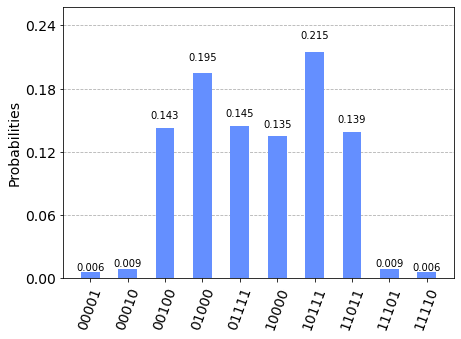

In [16]:
# Create a Quantum Circuit
meas = QuantumCircuit(qubit, qubit)
meas.barrier(range(qubit))
# map the quantum measurement to the classical bits
meas.measure(range(qubit), range(qubit))
circ = meas.compose(qc1, front=True)

## Noisy quantum circuit simulator backend
backend = Aer.get_backend('qasm_simulator')
job = backend.run(transpile(circ, backend), shots=1024)

# Grab the results from the job.
results_qasm = job.result()

counts = results_qasm.get_counts(circ)
print(counts)
plot_histogram(counts)


{'11000': 8, '01001': 9, '11001': 23, '10100': 35, '10010': 47, '10001': 56, '10011': 33, '01101': 50, '00101': 61, '01100': 40, '01110': 68, '10101': 51, '00111': 13, '01011': 41, '11010': 53, '00011': 157, '01010': 63, '11100': 186, '00110': 19, '10110': 11}


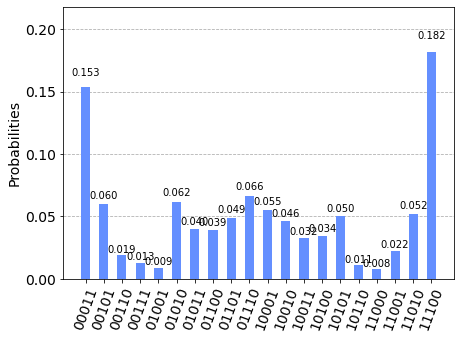

In [13]:
# Create a Quantum Circuit
meas = QuantumCircuit(qubit, qubit)
meas.barrier(range(qubit))
# map the quantum measurement to the classical bits
meas.measure(range(qubit), range(qubit))
circ = meas.compose(qc2, front=True)

## Noisy quantum circuit simulator backend
backend = Aer.get_backend('qasm_simulator')
job = backend.run(transpile(circ, backend), shots=1024)

# Grab the results from the job.
results_qasm = job.result()

counts = results_qasm.get_counts(circ)
print(counts)
plot_histogram(counts)


In [ ]:
import numpy as np
from scipy.linalg import expm
import numpy.linalg as LA
import random

from qiskit import QuantumCircuit
from qiskit import Aer, transpile,execute
from qiskit.quantum_info import random_pauli, state_fidelity, diamond_norm, Choi
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.tools.visualization import plot_histogram, plot_state_city

def create_entanglement(Nq, qc):
    qc.h(0)
    for i in range(1, Nq):
        qc.cx(0, i)
        
    qc.barrier()
    return qc

def create_hamiltonian(Nq, cn, gamma, Bn):

    XX= np.array(np.zeros(2**Nq))
    YY= np.array(np.zeros(2**Nq))
    Zn= np.array(np.zeros(2**Nq))
    Identity = 'I' * Nq
    hamiltonian = np.array(np.zeros(2**Nq))
    
    for k in range(0, Nq):
        
        # 一番端は今のところ計算しない
        if k == Nq-1:
            continue

        hamiX = Pauli(Identity[:k] + 'XX' + Identity[k+2:])
        hamiY = Pauli(Identity[:k] + 'YY' + Identity[k+2:])

        XX = XX + 0.5*cn[k]*(1+gamma)*hamiX.to_matrix()
        YY = YY + 0.5*cn[k]*(1-gamma)*hamiY.to_matrix()

    for k in range(0, Nq):
        hamiZ = Pauli(Identity[:k] + 'Z' + Identity[k+1:])
        Zn = Zn + Bn[k] * hamiZ.to_matrix()
    
    return XX + YY + Zn
